# Low-Vol systematic trading strategy

The strategy aims at benefiting from the low-volatility anomaly, by investing in a portfolio of security with the lowest annual volatility. 

In [1]:
import os
notebook_path = os.getcwd()
print(notebook_path)

/Users/stefanogrillini/Documents/Python/Coursera/EDHEC_Coursera_notebooks_and_codem01_v02/nb/My Strategies


In [2]:
path = "/Users/stefanogrillini/Documents/Python/Coursera/EDHEC_Coursera_notebooks_and_codem01_v02/nb/My Strategies/"
os.chdir(path)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import date
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import math
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')
import my_risk_kit as erk

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])
sp500_list[:100]

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP',
       'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN',
       'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD',
       'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME',
       'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV',
       'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB',
       'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB',
       'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG',
       'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG',
       'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL',
       'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC',
       'CNP'], dtype=object)

In [5]:
data = pd.DataFrame(columns = sp500_list[:100])
for i in data.columns:
    data[i] = yf.download(
    i, 
    start='2016-01-05', 
    end=date.today(),
    progress = False
)['Adj Close']

symbol_benchmark = "^SPX"
benchmark = yf.download(
    symbol_benchmark, 
    start='2016-01-05', 
    end=date.today()
)['Adj Close']


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


In [6]:
for col in data:
   if data[col].isna().sum() > 0:
      print(col)

BRK.B
BF.B
CARR


In [7]:
benchmark.isnull().values.any()

False

In [9]:
data.drop(['BRK.B','BF.B', 'CARR'], axis=1, inplace = True)
           
           
         #  , 'CDAY', 'CEG', 'CTVA', 'DOW', 'FTV'
         #  , 'FOXA', 'FOX', 'GEHC', 'HWM', 'IR', 'INVH', 'KVUE', 'LW'
         #  , 'MRNA', 'OGN', 'OTIS', 'VICI'], axis=1, inplace = True)

In [10]:
# Some summary stats of the selected stocks
returns = data.pct_change().shift(1)
returns.dropna(inplace = True)
bench_ret = benchmark.pct_change().shift(1)
erk.summary_stats(returns, riskfree_rate=0.04/250, periods_per_year=250)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
MMM,-0.008066,0.244066,-0.384060,12.366841,0.024021,0.037701,-0.033700,-0.560702
AOS,0.107435,0.277941,0.310265,7.456115,0.025182,0.039596,0.385903,-0.468063
ABT,0.141297,0.244889,-0.156575,9.848079,0.023362,0.035928,0.576242,-0.316732
ABBV,0.180068,0.265166,-0.665449,15.706545,0.025506,0.039147,0.678366,-0.450898
ACN,0.179928,0.255404,0.215006,9.678163,0.022593,0.038695,0.703744,-0.396878
...,...,...,...,...,...,...,...,...
CDW,0.251443,0.297115,-0.305475,11.440766,0.028224,0.043622,0.845608,-0.448341
CE,0.109491,0.326985,-0.399678,10.566705,0.032506,0.048325,0.334306,-0.533295
COR,0.088941,0.284335,-0.009680,10.402745,0.026432,0.042438,0.312191,-0.317552
CNC,0.082407,0.354484,-0.110919,10.474130,0.033619,0.050922,0.231982,-0.418165


In [11]:
# Let's start with a simple equally-weighted portfolio
ew_average = returns.mean(axis=1)
ew_portfolio = pd.DataFrame({'SP500': bench_ret, 'Equally-weighted average': ew_average}, index = returns.index)
ew_portfolio.isnull().values.any()

False

In [12]:
# arist_ew.interpolate(inplace = True)

In [13]:
ew_portfolio.corr()

,SP500,Equally-weighted average
SP500,1.000000,0.967479
Equally-weighted average,0.967479,1.000000


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.109986,0.187927,-0.544248,17.843834,0.017269,0.029285,0.358131,-0.339250
Equally-weighted average,0.166912,0.197935,-0.579174,18.914746,0.017851,0.030332,0.616603,-0.383103


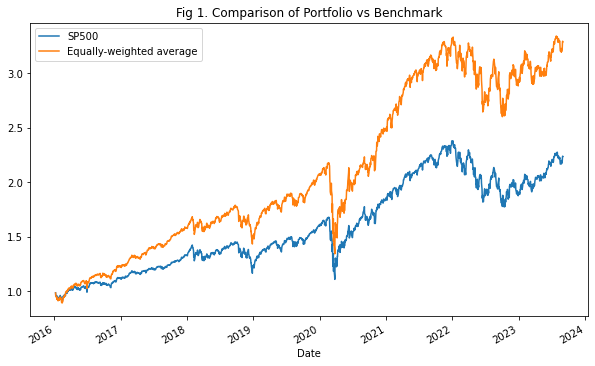

In [14]:
(1+ew_portfolio).cumprod().plot(figsize=(10,6), title="Fig 1. Comparison of Portfolio vs Benchmark")
erk.summary_stats(ew_portfolio.dropna(), riskfree_rate=0.04, periods_per_year=250)

Overall, a simple portfolio with equally weighted returns for all Dividend Aristocrats outperforms the index. Next step, we include some indicators to select a subset of stocks. 

In [15]:
# Convert from daily to monthly prices using 'M'
data_monthly = data.resample('M').last()

# Drop the columns with insufficient data
data_monthly_clean = data_monthly.dropna(axis=1)

In [16]:
data_monthly_clean.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,...,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,COR,CNC,CNP
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,116.267059,30.848150,32.970322,39.661053,93.252823,32.943642,28.415321,89.129997,70.767593,7.392311,...,42.007362,23.530001,51.135273,64.219391,27.969999,35.204670,53.964775,79.067108,31.030001,13.624855
2016-02-29,121.659538,31.192017,33.745571,39.451557,88.587524,29.963387,28.358234,85.150002,72.130318,7.625751,...,42.139801,24.270000,55.621109,60.247845,25.410000,36.340042,51.413235,76.769928,28.480000,14.405097
2016-03-31,129.228897,33.820164,36.437210,41.264832,101.964897,32.276985,29.453299,93.800003,76.882477,9.182031,...,46.366081,26.670000,62.883900,63.205479,28.820000,38.102867,55.809868,76.707863,30.785000,16.175772
2016-04-30,129.810516,34.326408,34.091961,44.491272,100.742355,32.877895,32.397816,94.220001,75.794083,8.768781,...,43.097523,29.530001,64.475975,59.945076,29.629999,35.348434,60.545410,75.422737,30.980000,16.585579
2016-05-31,131.408752,36.584606,34.731731,45.898960,106.139915,37.446648,34.972233,99.470001,75.279861,8.713779,...,42.237324,28.120001,60.153805,61.580112,29.850000,39.175194,60.357014,66.755585,31.174999,17.627281


## Build Low Vol indicator and loop across all dates

In [17]:
monthly_returns = data_monthly_clean.pct_change().shift(1)
monthly_returns = monthly_returns.dropna(axis=0)

# Low Vol indicator
vol_12 = data_monthly_clean.pct_change().rolling(window=12).std()
# Drop the 1 or 2 rows with NA's
vol_12 = vol_12.dropna(axis=0)

In [18]:
# Create a df for volatility ranks
vol_ranks = pd.DataFrame(index=vol_12.index, columns=vol_12.columns)

In [19]:
# Place each stock in a "quintile" bucket, at each "date" (rows)
for date in vol_ranks.index:
    row_values = vol_12.loc[date] # looping values each row
    ranks = pd.Series(row_values).rank(method='max') # set rank at each row
    quintiles = pd.qcut(ranks, q=5, labels=False) # divide into quintiles

    # Create dataframe with ranks for each stock at each month(4=high, 0=low)
    vol_ranks.loc[date] = quintiles 

In [20]:
quintile_dfs = {}
vol_returns = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns[quintile] = quintile_dfs[quintile].mean(axis=1).dropna()

In [21]:
vol_returns.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns.head()

,Very Low Vol,Low Vol,Medium,High Vol,Very High Vol
Date,,,,,
2016-12-31,0.021188,0.026904,0.024970,0.005242,0.044957
2017-01-31,0.021672,0.022396,0.026086,0.033148,-0.005878
2017-02-28,0.041942,0.055541,0.042349,0.063991,0.089715
2017-03-31,0.001353,0.011618,0.006866,0.011278,-0.022174
2017-04-30,0.023450,0.025555,0.016744,0.019411,0.001340


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Very Low Vol,0.150331,0.105197,-0.682109,3.642923,0.042642,0.060794,1.011734,-0.123801
Low Vol,0.166595,0.140069,-0.483921,3.231268,0.057528,0.076046,0.871789,-0.174729
Medium,0.129006,0.176100,-0.317551,2.981999,0.076141,0.097562,0.487331,-0.234056
High Vol,0.137696,0.207840,-0.440742,3.347972,0.092308,0.121754,0.453142,-0.312939
Very High Vol,0.180198,0.326252,-0.529193,6.796725,0.141885,0.192705,0.413956,-0.460765


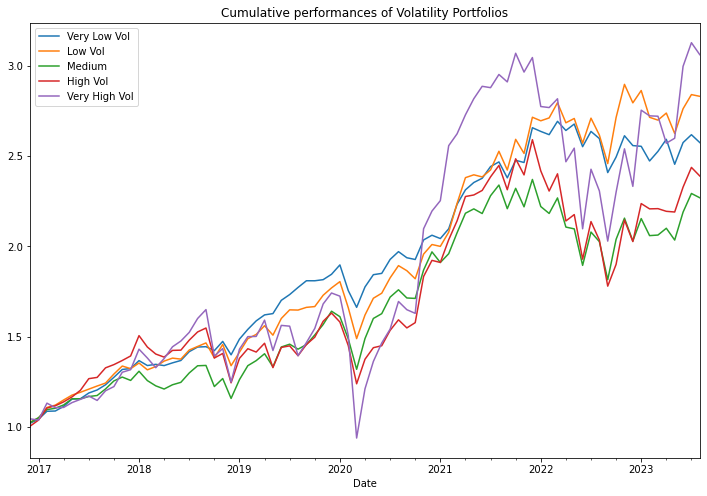

In [22]:
# Plot the cumulative return
(1+vol_returns).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
erk.summary_stats(vol_returns, riskfree_rate=0.04, periods_per_year=12)

In [23]:
# Convert from daily to monthly also the SP500
bench_monthly = benchmark.resample('M').last()
bench_ret_monthly = bench_monthly.pct_change()
bench_ret_monthly.isnull().values.any()

True

In [24]:
vol_ranks.columns[vol_ranks.iloc[-1] == 4]

Index(['ALK', 'ALB', 'ALGN', 'AMZN', 'AMD', 'AAL', 'APA', 'APTV', 'ANET',
       'AXON', 'BKR', 'BAC', 'BBWI', 'BWA', 'BXP', 'CZR', 'COF', 'CCL', 'CTLT',
       'CAT'],
      dtype='object')

In [25]:
bench_ret_monthly.dropna(inplace = True)

In [26]:
low_vol_df = pd.DataFrame({'SP500': bench_ret_monthly, 'Low Vol Portfolio': vol_returns['Very Low Vol']}, index = vol_returns.index)
low_vol_df.dropna(inplace = True)

In [27]:
low_vol_df.describe()

,SP500,Low Vol Portfolio
count,81.000000,81.000000
mean,0.010039,0.012196
std,0.047773,0.030368
min,-0.125119,-0.074844
25%,-0.011137,-0.004949
50%,0.017924,0.017573
75%,0.036022,0.033081
max,0.126844,0.078087


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.112211,0.165490,-0.496735,3.398506,0.074156,0.096472,0.420688,-0.247695
Low Vol Portfolio,0.150331,0.105197,-0.682109,3.642923,0.042642,0.060794,1.011734,-0.123801


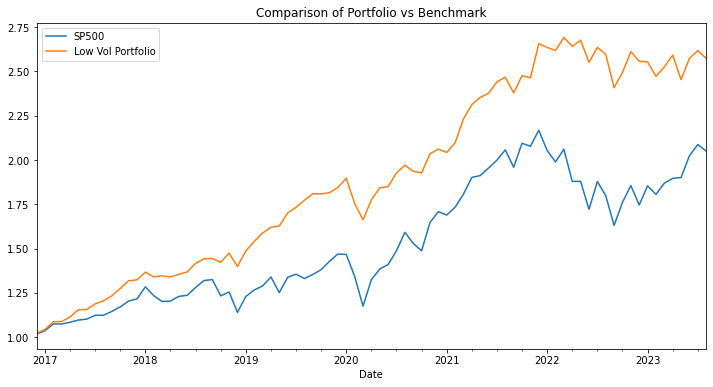

In [28]:
(1+low_vol_df).cumprod().plot(figsize=(12,6), title="Comparison of Portfolio vs Benchmark")
erk.summary_stats(low_vol_df.dropna(), riskfree_rate=0.04, periods_per_year=12)

The momentum signal for the portfolio improves the performances, with 30% annualized returns vs 5.8%, SR>1, lower drawdown and lower VaR. However, there is higher volatility. Next step is to make the portofolio market neutral. 

# Test the portfolio vs Fama - French 3 factor model + Carhart momentum

In [29]:
ff4 = gff.carhart4Factor(frequency = 'm')
ff4.rename(columns = {'date_ff_factors': 'Date'}, inplace = True)
ff4.set_index('Date', inplace = True)
ff4 = ff4['2016-05-01':]
ff4.head()

,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
2016-05-31,0.0178,-0.0017,-0.0166,0.0001,0.0142
2016-06-30,-0.0005,0.0061,-0.0148,0.0002,0.0413
2016-07-31,0.0395,0.0249,-0.0132,0.0002,-0.0334
2016-08-31,0.0049,0.0115,0.0318,0.0002,-0.0349
2016-09-30,0.0025,0.0212,-0.0124,0.0002,0.0019


In [30]:
ff_test = pd.concat([low_vol_df['Low Vol Portfolio'], ff4], axis=1)
monthly_returns
ff_test.dropna(axis = 0, inplace = True)

In [31]:
y, x = ff_test[['Low Vol Portfolio']], ff_test[['Mkt-RF', 'SMB', 'HML', 'MOM']]
x = sm.add_constant(x) 
est = sm.OLS(y, x).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Low Vol Portfolio   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     57.37
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           4.45e-22
Time:                        10:55:27   Log-Likelihood:                 222.54
No. Observations:                  80   AIC:                            -435.1
Df Residuals:                      75   BIC:                            -423.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.002      3.845      0.000       0.003       0.010
Mkt-RF         0.5559      0.040     13.927      0.000       0.476       0.635
SMB           -0.3251      0.069     -4.695      0.000      -0.463      -0.187
HML            0.1182      0.043      2.752      0.007       0.033       0.204
MOM            0.0545      0.051      1.071      0.287      -0.047       0.156
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.601
Skew:                          -0.058   Prob(JB):                        0.165
Kurtosis:                       4.033   Cond. No.                         41.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""